In [1]:
import torch
import numpy as np
import root_pandas
import pandas as pd

Welcome to JupyROOT 6.12/07


In [2]:
# Copy TTree HZZ4LeptonsAnalysisReduced into a pandas DataFrame.
filename = {
    'VV': root_pandas.read_root('data/ntuple_4mu_VV.root', key='HZZ4LeptonsAnalysisReduced'),
    'bkg': root_pandas.read_root('data/ntuple_4mu_bkg.root', key='HZZ4LeptonsAnalysisReduced')
}

# Drop all variables except for those we want to use when training.
VARS = ['f_mass4l','f_massjj']
df = {
    'VV': filename['VV'][VARS],
    'bkg': filename['bkg'][VARS],
}

In [3]:
# Make sure the inputs are well behaved.
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

In [4]:
# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

In [5]:
# Combine signal and background into one DataFrame then split into input variables and labels.
NDIM = len(VARS)
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

# Split into training and testing data.
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print(X_train_val)
print(X)

# preprocessing: standard scalar (reshape inputs to mean=0, variance=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Split again, this time into training and validation data.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=7)

[[ 123.59499359 1071.21447754]
 [ 124.97003174 1074.65454102]
 [ 124.32479095  643.70874023]
 ...
 [  87.93131256  538.8001709 ]
 [ 120.99951935  772.50964355]
 [  90.16904449  194.7850647 ]]
[[ 125.07710266 1300.42687988]
 [ 124.2381134   437.22186279]
 [ 124.48066711 1021.74407959]
 ...
 [  89.28808594   53.66157913]
 [ 146.75657654   71.16202545]
 [ 218.86941528   98.91469574]]


In [6]:
# Build our model. 
import torch
model = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

# Use Binary Cross Entropy as our loss function.
loss_fn = torch.nn.BCELoss()

# Optimize the model parameters using the Adam optimizer.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
import math
def getBatches(N, tot):
    """Function to find nearest acceptable batch size"""
    print N, tot
    if tot % N == 0:
        return N
    closest = 1
    for i in xrange(1, N):
        if tot % i == 0 and abs(N - i) < abs(N-closest):
            closest = i
    return closest
    
# Create batches from total data. We have to make sure the batch size is an appropriate divisor of the total 
# number of training events
N = getBatches(1024, len(X_train))
unbatched_x = torch.from_numpy(X_train).float()
x = unbatched_x.view(-1, N, len(VARS))
unbatched_y = torch.from_numpy(Y_train).float()
y_b = unbatched_y.view(-1, N, 1)

1024 13272


In [8]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [9]:
losses, val_losses = [], []
min_loss, stale_epochs = 100., 0

# 500 epochs. 
for t in xrange(500):
    batch_loss, val_batch_loss = [], []
    for b in xrange(len(x)):
        
        # Forward pass: make a prediction for each x event in batch b.
        y_pred = model(x[b])

        # Get the labels.
        label = y_b[b]
        y = label.view_as(y_pred)  # reshape label data to the shape of y_pred

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        batch_loss.append(loss.item())

        # Let's look at the validation set.
        
        # Torch keeps track of each operation performed on a Tensor, so that it can take the gradient later.
        # We don't need to store this information when looking at validation data, so turn it off with
        # torch.no_grad().
        with torch.no_grad():
            
            # Forward pass on validation set.
            output = model(val_data)

            # Get labels and compute loss again
            val_y = val_label.view_as(output)
            val_loss = loss_fn(output, val_y)
            val_batch_loss.append(val_loss.item())

            # Monitor the loss function to prevent overtraining.
            if stale_epochs > 20:
                break

            if val_loss.item() - min_loss < 0:
                min_loss = val_loss.item()
                stale_epochs = 0
            else:
                stale_epochs += 1

        #print(t, b, loss.item(), val_loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    losses.append(min(batch_loss))
    val_losses.append(min(val_batch_loss))

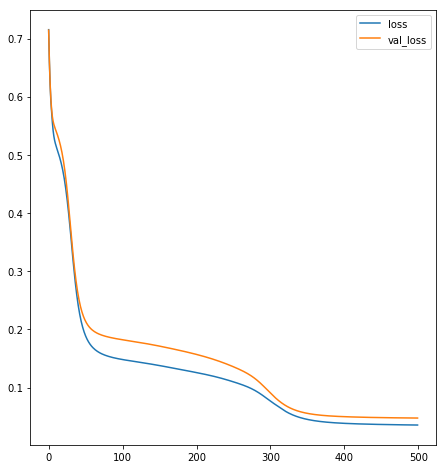

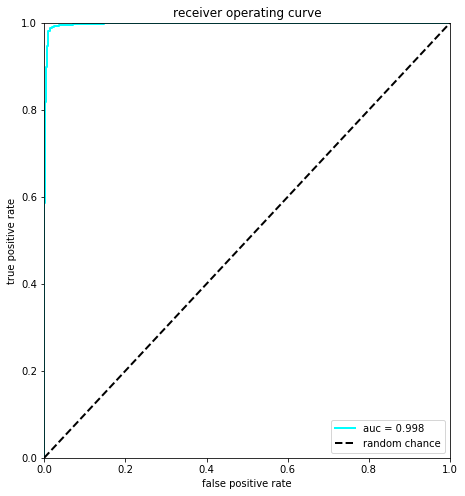

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(16,8))
    ax = plt.subplot(1, 2, 1)
    ax.plot(losses, label='loss')
    ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    plt.show()


    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(16,8))
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax2.set_xlim([0, 1.0])
    ax2.set_ylim([0, 1.0])
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('receiver operating curve')
    ax2.legend(loc="lower right")
    plt.show()

In [11]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

myZI = np.zeros(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        data_point = torch.tensor([myXI[i,j], myYI[i,j]])
        myZI[i,j] = model(data_point)

(200, 200)


In [12]:
print(myZI)
myZI = model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.reshape(myXI.shape)

[[0.05663394 0.0566166  0.0565994  ... 0.00227242 0.00227528 0.0022781 ]
 [0.05666762 0.05665022 0.05663298 ... 0.00227798 0.00228079 0.00228354]
 [0.056702   0.05668453 0.05666732 ... 0.0022835  0.00228624 0.00228893]
 ...
 [0.17088257 0.17318054 0.17560327 ... 0.00322377 0.00321212 0.00320089]
 [0.17223877 0.17458817 0.17706698 ... 0.00323275 0.00322089 0.00320945]
 [0.17361118 0.1760141  0.17855167 ... 0.00324183 0.00322975 0.0032181 ]]


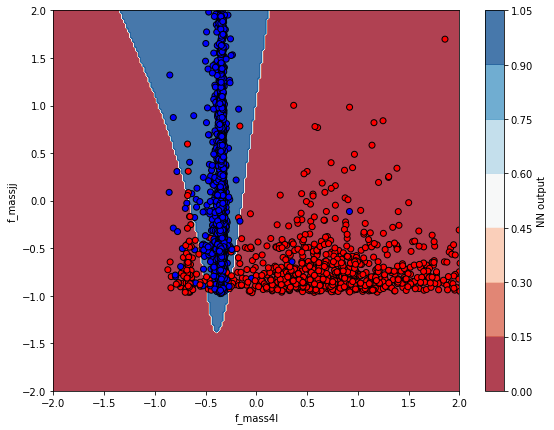

In [13]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points

In [14]:
# -*- coding: utf-8 -*-
import random
import torch


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.sig(self.output_linear(h_relu))
        return y_pred


# Construct our model by instantiating the class defined above
rand_model = DynamicNet(2, 20, 1)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
rand_losses = []
for t in xrange(3000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = rand_model(unbatched_x)

    # Compute and print loss
    y = unbatched_y.view_as(y_pred)
    loss = criterion(y_pred, y)
    rand_losses.append(loss.item())
    #print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

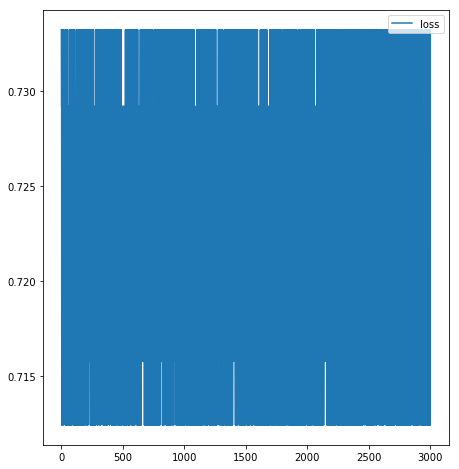

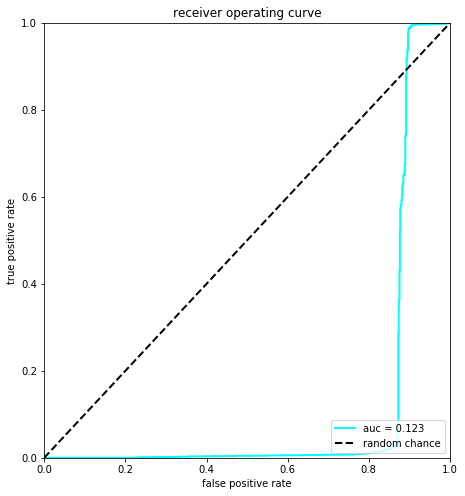

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(16,8))
    ax = plt.subplot(1, 2, 1)
    ax.plot(rand_losses, label='loss')
#     ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    plt.show()


    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = rand_model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(16,8))
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax2.set_xlim([0, 1.0])
    ax2.set_ylim([0, 1.0])
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('receiver operating curve')
    ax2.legend(loc="lower right")
    plt.show()

In [16]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

myZI = np.zeros(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        data_point = torch.tensor([myXI[i,j], myYI[i,j]])
        myZI[i,j] = rand_model(data_point)

(200, 200)


In [17]:
print(myZI)
myZI = rand_model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.reshape(myXI.shape)

[[0.55394709 0.48562676 0.55463034 ... 0.50716615 0.5439195  0.54382914]
 [0.48563442 0.55328846 0.55365866 ... 0.48705611 0.54302883 0.50761807]
 [0.48556826 0.5524022  0.55268669 ... 0.48705643 0.54214376 0.54205936]
 ...
 [0.40461126 0.48260999 0.48539948 ... 0.50105995 0.49907747 0.51307333]
 [0.5037365  0.50367785 0.40509409 ... 0.50120181 0.45474342 0.45481727]
 [0.48563868 0.50401068 0.40475231 ... 0.51291823 0.51326174 0.45495501]]


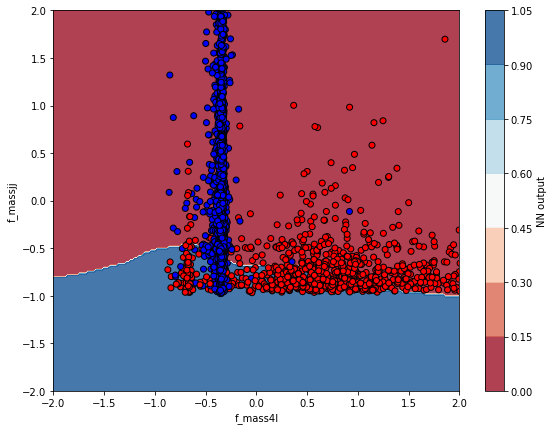

In [18]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points